<a href="https://colab.research.google.com/github/TurkuNLP/intro-to-nlp/blob/master/w2v_gensim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gensim

* A useful library specifically for dealing with static word embeddings: their training and loading
* https://radimrehurek.com/gensim/auto_examples/index.html#documentation
* For our purposes, this library is really easy to use

# Embedding repositories

* Repository: a collection of pre-trained embeddings
* Gensim's own: https://github.com/RaRe-Technologies/gensim-data
* NLPL vectors: http://vectors.nlpl.eu/repository/

In [ ]:
import gensim

In [1]:
# I found this link in the NLPL repository
# It refers to English model trained on the Gigaword corpus of news
!wget http://vectors.nlpl.eu/repository/20/12.zip
# And this is Finnish, trained on a web crawl data we created back then: https://lindat.mff.cuni.cz/repository/xmlui/handle/11234/1-1989
!wget http://vectors.nlpl.eu/repository/20/42.zip


--2023-04-17 19:09:39--  http://vectors.nlpl.eu/repository/20/12.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.181
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 613577258 (585M) [application/zip]
Saving to: ‘12.zip’

12.zip              100%[===================>] 585.15M  5.66MB/s    in 98s     

2023-04-17 19:11:17 (5.99 MB/s) - ‘12.zip’ saved [613577258/613577258]

--2023-04-17 19:11:17--  http://vectors.nlpl.eu/repository/20/42.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.181
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1849124328 (1.7G) [application/zip]
Saving to: ‘42.zip’

42.zip              100%[===================>]   1.72G   926KB/s    in 17m 5s  

2023-04-17 19:28:23 (1.72 MB/s) - ‘42.zip’ saved [1849124328/1849124328]



In [2]:
# Somewhat awkwardly, these are numbered files and both
# .zip files contain "model.bin"
# Let's unzip and rename
# -o means "do not ask, overwrite by default"
!unzip -o 12.zip
!mv model.bin en.bin
!unzip -o 42.zip
!mv model.bin fi.bin


Archive:  12.zip
  inflating: meta.json               
  inflating: model.bin               
  inflating: model.txt               
  inflating: README                  
Archive:  42.zip
  inflating: LIST                    
  inflating: meta.json               
  inflating: model.bin               
  inflating: model.txt               
  inflating: README                  




*   Now we can load the embeddings
*   These are huge, but they are sorted by frequency, so we can easily limit ourselves to the top 100,000 words, which will be plenty enough for us
*   This is maybe good to note, now we enter the territory of NLP models which count in the gigabytes in size



In [3]:
# This is how you load the trained embeddings
# check the documentation
# w2v embeddings are traditionlly distributed in one of two formats: a text form, and a binary form
# The embeddings we downloaded above are in the binary form, so we need to indicate that when loading

from gensim.models import KeyedVectors

wv_emb_en=KeyedVectors.load_word2vec_format("en.bin", limit=100000, binary=True)
wv_emb_fi=KeyedVectors.load_word2vec_format("fi.bin", limit=100000, binary=True)

`KeyedVectors` documentation is here: https://radimrehurek.com/gensim/models/keyedvectors.html

# Basic operations with the embeddings

* The KeyedVectors object allows for all the basic operations with embeddings which we saw in the lecture


# Nearest word lookup

* Lookup by word
* I.e. retrieve the embedding of a word, then find its nearest neighbors (typically under cosine similarity) and list them

In [4]:
result = wv_emb_en.similar_by_word('cat')
for most_similar_key, similarity in result[:10]:
    print(f"{most_similar_key}: {similarity:.4f}")

dog: 0.8098
cats: 0.7977
mutt: 0.7505
kitten: 0.7471
feline: 0.7438
puppy: 0.7252
raccoon: 0.7183
pooch: 0.7116
squirrel: 0.6906
kittens: 0.6856


# Word analogy

* "A is to B as C is to D"
* Can be implemented as D=B-A+C, where (A,B,C) are word embeddings
* Then list words nearest to the computed embedding D
* In the library, the implementation lets us list words with "+" sign, and words with "-" sign


In [5]:
# B     A      C
# Paris-France+Sweden= ___?
#
# i.e. France is to Paris as Sweden is to X
wv_emb_en.most_similar(positive=["Paris","Sweden"],negative=["France"])

[('Stockholm', 0.7338932752609253),
 ('Malmo', 0.5458161234855652),
 ('Helsinki', 0.5444940328598022),
 ('Goteborg', 0.5421050190925598),
 ('Swedish', 0.5309098362922668),
 ('Malmoe', 0.5198634266853333),
 ('Oslo', 0.5004472732543945),
 ('Gothenburg', 0.4957912266254425),
 ('STOCKHOLM', 0.48791587352752686),
 ('Copenhagen', 0.47769418358802795)]

In [6]:
triples=[("cow","milk","hen"),
         ("Paris","France","Helsinki"),
         ("car","wheel","airplane"),
         ("airplane","propeller","ship"),
         ("king","queen","man"),
         ("man","doctor","woman"),
         ("man","boss","woman")
         ]
for what,is_to_what,as_this_is in triples:
    # is_to_what-what+as_this_is
    to_what=wv_emb_en.most_similar(positive=[is_to_what,as_this_is],negative=[what])[0][0]
    print(f"{what} is to {is_to_what} as {as_this_is} is to: {to_what}")


cow is to milk as hen is to: sauce
Paris is to France as Helsinki is to: Finland
car is to wheel as airplane is to: rudder
airplane is to propeller as ship is to: vessel
king is to queen as man is to: woman
man is to doctor as woman is to: physician
man is to boss as woman is to: bosses


# Cross-lingual transfer

* Among the most impressive demonstrations of word embeddings
* Given a list of word pairs between two languages (source and target), one can induce a mapping matrix $M$ which performs a linear transformation of the source language embeddings onto the target language embeddings
* This basically "aligns" the source language embedding space onto the target language embedding space

This is well worth testing! Let's try!

## Bilingual dictionaries

* There are many sources, for example this one:
* https://github.com/codogogo/xling-eval
* The associated paper is here: https://aclanthology.org/P19-1070/

In [7]:
# Grab the data
!wget https://raw.githubusercontent.com/codogogo/xling-eval/master/bli_datasets/en-fi/yacle.test.freq.2k.en-fi.tsv
!wget https://raw.githubusercontent.com/codogogo/xling-eval/master/bli_datasets/en-fi/yacle.train.freq.5k.en-fi.tsv


--2023-04-17 19:29:32--  https://raw.githubusercontent.com/codogogo/xling-eval/master/bli_datasets/en-fi/yacle.test.freq.2k.en-fi.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35770 (35K) [text/plain]
Saving to: ‘yacle.test.freq.2k.en-fi.tsv’

yacle.test.freq.2k. 100%[===================>]  34.93K  --.-KB/s    in 0.004s  

2023-04-17 19:29:32 (9.03 MB/s) - ‘yacle.test.freq.2k.en-fi.tsv’ saved [35770/35770]

--2023-04-17 19:29:32--  https://raw.githubusercontent.com/codogogo/xling-eval/master/bli_datasets/en-fi/yacle.train.freq.5k.en-fi.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... co

In [8]:
!cat yacle.test.freq.2k.en-fi.tsv | head -n 10

dedication	omistautuminen
desires	toiveet
dismissed	hylätty
psychic	psyykkinen
cracks	halkeamia
establishments	laitokset
efficacy	tehokkuus
prestige	arvovalta
cocaine	kokaiini
accelerated	kiihtyi


In [10]:
pairs_train=[] #These will be pairs of (source,target) i.e. (Finnish, English) words used to induce the matrix M
pairs_test=[]  #same but for testing, so we should make sure there is absolutely no overlap between the train and test data
               #let's do it so that not one word in the test is is seen in any capacity in the training data

import csv

def get_vectors(fname):
    """
    Read the pairs from the file `fname`
    """
    pairs=[]
    with open(fname) as f:
        r = csv.reader(f,delimiter="\t") #the file is a .tsv i.e. tab-separated-values
        for en_word,fi_word in r:
            #I will reverse the order here, go from Finnish as the source, to English as the target
            #That way it will be easier to check how this works using English as the target, which we all understand
            pairs.append((fi_word,en_word))
        return pairs

train_data=get_vectors("yacle.train.freq.5k.en-fi.tsv")
test_data=get_vectors("yacle.test.freq.2k.en-fi.tsv")
print(train_data[:10])
print(len(train_data))
print(test_data[:10])
print(len(test_data))



[('of', 'of'), ('että', 'to'), ('sisään', 'in'), ('varten', 'for'), ('on', 'is'), ('päällä', 'on'), ('että', 'that'), ('mennessä', 'by'), ('Tämä', 'this'), ('kanssa', 'with')]
5000
[('omistautuminen', 'dedication'), ('toiveet', 'desires'), ('hylätty', 'dismissed'), ('psyykkinen', 'psychic'), ('halkeamia', 'cracks'), ('laitokset', 'establishments'), ('tehokkuus', 'efficacy'), ('arvovalta', 'prestige'), ('kokaiini', 'cocaine'), ('kiihtyi', 'accelerated')]
2000


## Get the embeddings

* Now we have the word pairs
* We need the embeddings, so we can build our S and T matrices
* Not all words will be in our W2V embeddings
* Plus, we want to be 100% sure there is absolutely no overlap between the training and test data
* This means not one word seen in the training data will be in the test data
* The general approach will be to gather the vectors into a list, and then vstack (vertical stack) these to get a 2D array, i.e. a matrix

In [11]:
import numpy

def build_arrays(pairs,emb1,emb2,avoid=set()):
    """
    `pairs`: pairs of (fi,en) words
    `emb1`: source side (here Finnish) embeddings
    `emb2`: target side (here English) embeddings
    `avoid`: a set of words to avoid/ignore (will be used when building test data, to avoid train data)
    """
    vecs1,vecs2,filtered_pairs=[],[],[]  #vectors for source words, vectors for target words, and the word pairs themselves, i.e. three same-length lists
    for w1,w2 in pairs: #Go over all pairs that we got
        # check if both vectors are available, and none of the words is to be avoided
        if w1 in emb1 and w2 in emb2 and w1 not in avoid and w2 not in avoid:
            #passed!
            vecs1.append(emb1[w1]) #source-side embedding, the KeyedVectors object can be queried as if it was a dictionary, returns the embedding as 1-dim array
            vecs2.append(emb2[w2]) #target-side embeddings
            filtered_pairs.append((w1,w2)) #remember the pair
    #Now we vstack() which turns the lists of embeddings into 2-dim array
    return numpy.vstack(vecs1),numpy.vstack(vecs2),filtered_pairs

# Gather the train data first
array_train_fi,array_train_en,pairs_train=build_arrays(train_data,wv_emb_fi,wv_emb_en)
# Now build the set of all words seen in training, so we can avoid them when building the test set. Note that "|" is set union operator
everything_in_train=set(s for s,t in pairs_train)|set(t for s,t in pairs_train)
# Test data next, avoiding the words from the training data:
array_test_fi,array_test_en,pairs_test=build_arrays(test_data,wv_emb_fi,wv_emb_en,avoid=everything_in_train)

In [12]:
# Let's be super-sure there absolutely is no overlap of any kind!
print("Overlap between train pairs and test pairs:",len(set(pairs_train) & set(pairs_test))) # & is set intersection operator, intersection between train and test should be empty
src_train=set(src_w for src_w,tgt_w in pairs_train) #train source words
tgt_train=set(tgt_w for src_w,tgt_w in pairs_train) #train target words
src_test=set(src_w for src_w,tgt_w in pairs_test)   #test source words
tgt_test=set(tgt_w for src_w,tgt_w in pairs_test)   #test target words
print("Overlap between train fi words and test fi words:",len(src_train & src_test))
print("Overlap between train en words and test en words:",len(tgt_train & tgt_test))

Overlap between train pairs and test pairs: 0
Overlap between train fi words and test fi words: 0
Overlap between train en words and test en words: 0


## Mapping matrix
* Next we need to induce the transformation matrix
* I.e. implement the least-squares methods from the lecture
* Surely GPT4 can write this for us:

In [14]:
# This code was written by GPT4, but in a bit of a twisted form, so I modified it
# to better correspond to the formulae in the lecture

def learn_transformation_matrix(source, target):
    # Compute the pseudo-inverse of the source matrix
    source_pseudo_inverse = numpy.linalg.pinv(source) # This implements (S^T S)^-1 S^T  needed in the least-squares formula in the lecture slides
    # Compute the transformation matrix M using least squares method
    M = numpy.matmul(source_pseudo_inverse,target)  #...and this multiplies by T from right completing the formula in the slides ... two lines(!)
    return M

# fi -> en matrix
M=learn_transformation_matrix(array_train_fi,array_train_en)

# Ha ha well that was easy

In [17]:
print("Source (fi) shape",array_train_fi.shape)
print("Target (en) shape",array_train_en.shape)
print("M shape",M.shape)


Source (fi) shape (4506, 100)
Target (en) shape (4506, 300)
M shape (100, 300)


In [19]:
# And now we transform the source (Finnish) test embeddings into the English embedding space
# using the matrix M
test_fi_transformed=numpy.matmul(array_test_fi,M) # This corresponds to SM in the lecture slides, i.e. source transformed by M to the target embedding space
print("Transformed shape:",test_fi_transformed.shape)
numpy.square(numpy.subtract(test_fi_transformed, array_test_en)).mean() #This is the mean square error of the actual target, and the transformed source, looks small enough :)

Transformed shape: (1285, 300)


0.002326297

* So now we have the originally Finnish embeddings transformed into the English space
* How can we evaluate?

1. Go over the test word pairs (fi,en)
2. Use the transformed Finnish embedding as a query into the English space
3. List top-N English words which appear near this transformed embedding

Conceptually, we go: "Finnish word -> lookup to Finnish vector -> multiply by M to get English vector -> lookup English words nearby"

In [21]:
for i,(w1,w2) in enumerate(pairs_test[:50]):
    print(f"{w1} (in English {w2}):")
    nearest_neighbors=wv_emb_en.similar_by_vector(test_fi_transformed[i]) #lookup the nearest
    #nearest_neigbors will be tuples (word,similarity_value)
    eng_words=[w for w, score in nearest_neighbors] #just grab the words
    print(f"   ",", ".join(eng_words)) #...and print then ,-separated
    print()

# It cannot be stressed enough, that none of the words in the test data were seen
# during the induction of the transformation matrix M
# 
# We can observe some direct top-1 hits, and in general we see
# the mapping maps the vector very close to the correct place
# in my view, this is quite impressive :)

toiveet (in English desires):
    desires, importantly, Certainly, qualities, ideas, perspectives, desire, indeed, sense, notions

psyykkinen (in English psychic):
    cognitive, physiological, behavioral, physical, neurological, mental, disorders, empathy, therapy, interpersonal

halkeamia (in English cracks):
    crevices, vegetation, gullies, surfaces, ridges, walls, limestone, reddish, mottled, sediment

kokaiini (in English cocaine):
    additives, pesticides, substances, caffeine, foods, carcinogenic, medications, drugs, side-effects, chemicals

kiihtyi (in English accelerated):
    slowed, worsened, accelerated, surged, exacerbated, spurred, stagnated, slackened, fueled, ebbed

huippu (in English pinnacle):
    magnificent, breathtaking, ideal, marvelous, majestic, perfect, beautiful, gorgeous, fabulous, awesome

edellä (in English supra):
    therefore, although, instances, indeed, simply, Furthermore, merely, Consequently, fact, actually

päärynä (in English pear):
    melon, 

# Visualization

* I asked GPT4 to visualize the data for us
* Below is the code it produced, after a little bit of back-and-forth
* Do read it with some thought, it's quite informative


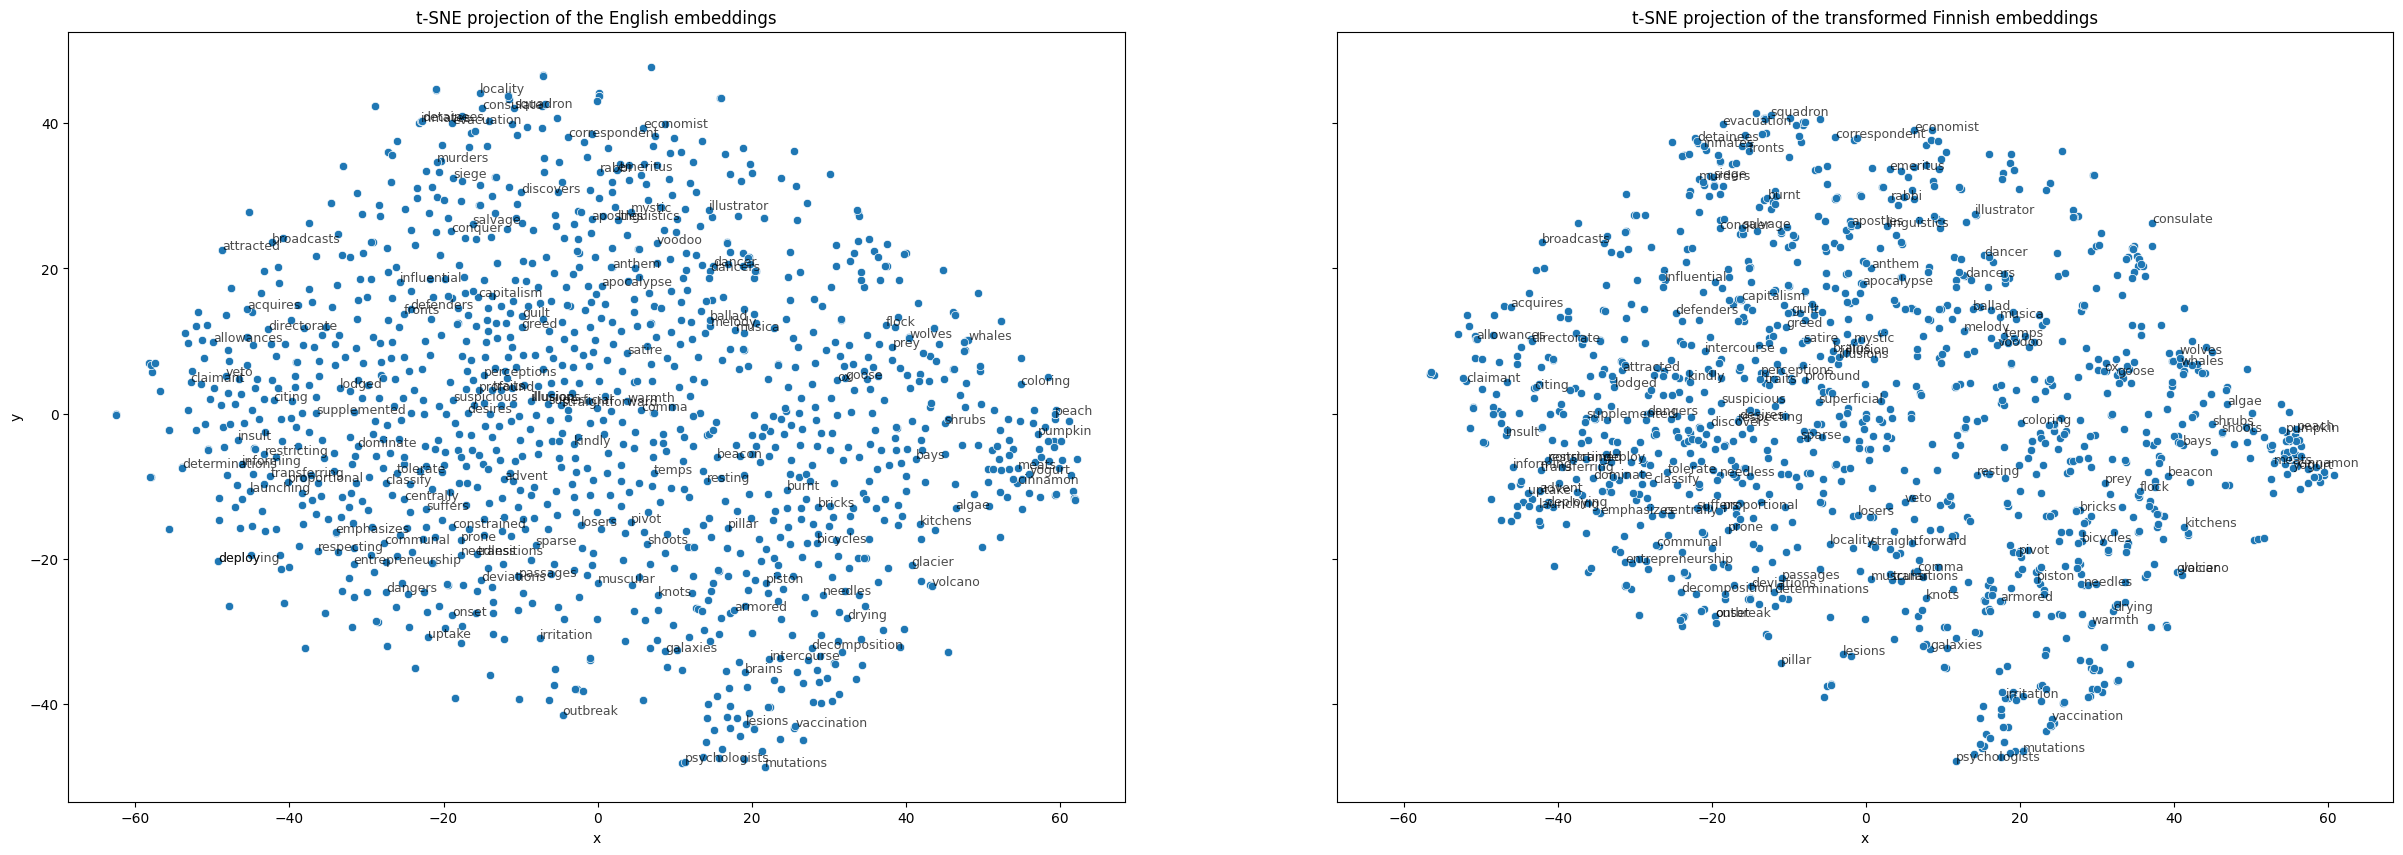

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE

embeddings1 = array_test_en
words1 = [en for fi,en in pairs_test]

embeddings2 = test_fi_transformed
words2 = words1

# Concatenate the embeddings and perform t-SNE dimensionality reduction
combined_embeddings = np.concatenate((embeddings1, embeddings2), axis=0)
tsne = TSNE(n_components=2, random_state=42)
combined_embeddings_2d = tsne.fit_transform(combined_embeddings)

# Separate the transformed embeddings
embeddings1_2d = combined_embeddings_2d[:len(embeddings1)]
embeddings2_2d = combined_embeddings_2d[len(embeddings1):]

# Prepare the data for plotting
plot_data1 = {"x": embeddings1_2d[:, 0], "y": embeddings1_2d[:, 1], "labels": words1}
df1 = pd.DataFrame(plot_data1)

plot_data2 = {"x": embeddings2_2d[:, 0], "y": embeddings2_2d[:, 1], "labels": words2}
df2 = pd.DataFrame(plot_data2)

# Create the t-SNE plots using seaborn side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10), sharex=True, sharey=True)

sns.scatterplot(data=df1, x="x", y="y", ax=ax1)
sns.scatterplot(data=df2, x="x", y="y", ax=ax2)

# Annotate every 10th point with the corresponding word labels
for i, txt in enumerate(df1["labels"]):
    if i % 10 == 0:
        ax1.annotate(txt, (df1["x"][i], df1["y"][i]), fontsize=9, alpha=0.7)

for i, txt in enumerate(df2["labels"]):
    if i % 10 == 0:
        ax2.annotate(txt, (df2["x"][i], df2["y"][i]), fontsize=9, alpha=0.7)

ax1.set_title("t-SNE projection of the English embeddings")
ax2.set_title("t-SNE projection of the transformed Finnish embeddings")
plt.show()

# Full log of the GPT4 conversation which led to the code above


Person: 
- I have a matrix with word embeddings, and a list of words. Please write me a single block of python which will plot the tSNE projection of the embeddings labeled by the words. Some nice plot, maybe with sunborn or plotly. Mus be runnable in colab. Thank you!

ChatGPT: 
- Here's a code block that you can use to visualize the t-SNE projection of your word embeddings using the seaborn library in a Google Colab notebook. Make sure to install seaborn first by running `!pip install seaborn` in a separate cell.

```python

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Replace these with your own data
embeddings = np.random.rand(50, 300)
words = [f"word_{i}" for i in range(50)]

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Prepare the data for plotting
plot_data = {"x": embeddings_2d[:, 0], "y": embeddings_2d[:, 1], "labels": words}
df = pd.DataFrame(plot_data)

# Create the t-SNE plot using seaborn
plt.figure(figsize=(15, 10))
sns.scatterplot(data=df, x="x", y="y")

# Annotate the points with the corresponding word labels
for i, txt in enumerate(df["labels"]):
    plt.annotate(txt, (df["x"][i], df["y"][i]), fontsize=9, alpha=0.7)

plt.title("t-SNE projection of word embeddings")
plt.show()
```



Replace `embeddings` and `words` with your own data. This code will create a t-SNE plot using seaborn and display it in the output. The points in the plot will be labeled with the corresponding words from the `words` list.

Person: 
- Can you modify the code so that I could plot another set of embeddings in a plot side-by-side to the original one

ChatGPT: 
- Certainly! Here's the updated code that plots two sets of word embeddings side by side using subplots:

```python

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE

# Replace these with your own data
embeddings1 = np.random.rand(50, 300)
words1 = [f"word1_{i}" for i in range(50)]

embeddings2 = np.random.rand(50, 300)
words2 = [f"word2_{i}" for i in range(50)]

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embeddings1_2d = tsne.fit_transform(embeddings1)
embeddings2_2d = tsne.fit_transform(embeddings2)

# Prepare the data for plotting
plot_data1 = {"x": embeddings1_2d[:, 0], "y": embeddings1_2d[:, 1], "labels": words1}
df1 = pd.DataFrame(plot_data1)

plot_data2 = {"x": embeddings2_2d[:, 0], "y": embeddings2_2d[:, 1], "labels": words2}
df2 = pd.DataFrame(plot_data2)

# Create the t-SNE plots using seaborn side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10), sharex=True, sharey=True)

sns.scatterplot(data=df1, x="x", y="y", ax=ax1)
sns.scatterplot(data=df2, x="x", y="y", ax=ax2)

# Annotate the points with the corresponding word labels
for i, txt in enumerate(df1["labels"]):
    ax1.annotate(txt, (df1["x"][i], df1["y"][i]), fontsize=9, alpha=0.7)

for i, txt in enumerate(df2["labels"]):
    ax2.annotate(txt, (df2["x"][i], df2["y"][i]), fontsize=9, alpha=0.7)

ax1.set_title("t-SNE projection of word embeddings 1")
ax2.set_title("t-SNE projection of word embeddings 2")
plt.show()
```



Replace `embeddings1`, `words1`, `embeddings2`, and `words2` with your own data. This code will create two t-SNE plots side by side using seaborn and display them in the output. The points in the plots will be labeled with the corresponding words from the `words1` and `words2` lists.

Person: 
- OMG this is excellent, and works on first try. But can you modify it so that only every 10th word annotation is printed, the texts overlap in the plot and are not readable.

ChatGPT: 
- Of course! I have updated the code to only annotate every 10th word in both plots. This should help with the readability of the text labels.

```python

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE

# Replace these with your own data
embeddings1 = np.random.rand(50, 300)
words1 = [f"word1_{i}" for i in range(50)]

embeddings2 = np.random.rand(50, 300)
words2 = [f"word2_{i}" for i in range(50)]

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embeddings1_2d = tsne.fit_transform(embeddings1)
embeddings2_2d = tsne.fit_transform(embeddings2)

# Prepare the data for plotting
plot_data1 = {"x": embeddings1_2d[:, 0], "y": embeddings1_2d[:, 1], "labels": words1}
df1 = pd.DataFrame(plot_data1)

plot_data2 = {"x": embeddings2_2d[:, 0], "y": embeddings2_2d[:, 1], "labels": words2}
df2 = pd.DataFrame(plot_data2)

# Create the t-SNE plots using seaborn side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10), sharex=True, sharey=True)

sns.scatterplot(data=df1, x="x", y="y", ax=ax1)
sns.scatterplot(data=df2, x="x", y="y", ax=ax2)

# Annotate every 10th point with the corresponding word labels
for i, txt in enumerate(df1["labels"]):
    if i % 10 == 0:
        ax1.annotate(txt, (df1["x"][i], df1["y"][i]), fontsize=9, alpha=0.7)

for i, txt in enumerate(df2["labels"]):
    if i % 10 == 0:
        ax2.annotate(txt, (df2["x"][i], df2["y"][i]), fontsize=9, alpha=0.7)

ax1.set_title("t-SNE projection of word embeddings 1")
ax2.set_title("t-SNE projection of word embeddings 2")
plt.show()
```



Now, the code will only annotate every 10th word in both plots, which should make the text labels more readable.

Person: 
- Hmm, but is there a way to use the t-SNE projection learned on embeddings 1 to plot embeddings 2? I would kinda need them to be aligned in this sense.

ChatGPT: 
- Yes, you can use the same t-SNE model trained on embeddings1 to transform embeddings2. This will help you align the projections of both embeddings sets. Here's the updated code:

```python

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE

# Replace these with your own data
embeddings1 = np.random.rand(50, 300)
words1 = [f"word1_{i}" for i in range(50)]

embeddings2 = np.random.rand(50, 300)
words2 = [f"word2_{i}" for i in range(50)]

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embeddings1_2d = tsne.fit_transform(embeddings1)
embeddings2_2d = tsne.transform(embeddings2)

# Prepare the data for plotting
plot_data1 = {"x": embeddings1_2d[:, 0], "y": embeddings1_2d[:, 1], "labels": words1}
df1 = pd.DataFrame(plot_data1)

plot_data2 = {"x": embeddings2_2d[:, 0], "y": embeddings2_2d[:, 1], "labels": words2}
df2 = pd.DataFrame(plot_data2)

# Create the t-SNE plots using seaborn side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10), sharex=True, sharey=True)

sns.scatterplot(data=df1, x="x", y="y", ax=ax1)
sns.scatterplot(data=df2, x="x", y="y", ax=ax2)

# Annotate every 10th point with the corresponding word labels
for i, txt in enumerate(df1["labels"]):
    if i % 10 == 0:
        ax1.annotate(txt, (df1["x"][i], df1["y"][i]), fontsize=9, alpha=0.7)

for i, txt in enumerate(df2["labels"]):
    if i % 10 == 0:
        ax2.annotate(txt, (df2["x"][i], df2["y"][i]), fontsize=9, alpha=0.7)

ax1.set_title("t-SNE projection of word embeddings 1")
ax2.set_title("t-SNE projection of word embeddings 2")
plt.show()
```



In this code, we use `tsne.transform(embeddings2)` instead of `tsne.fit_transform(embeddings2)` to apply the same t-SNE transformation learned from embeddings1 to embeddings2. This will ensure that both embeddings sets are aligned in the t-SNE space.

Person: 
- I get an error which says tsne has no transform()

ChatGPT: 
- Apologies for the confusion. You are correct; t-SNE does not have a transform() method in scikit-learn. Instead, we can use the `fit` method with both embeddings concatenated and then separate the transformed data for plotting.

Here's the updated code:

```python

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE

# Replace these with your own data
embeddings1 = np.random.rand(50, 300)
words1 = [f"word1_{i}" for i in range(50)]

embeddings2 = np.random.rand(50, 300)
words2 = [f"word2_{i}" for i in range(50)]

# Concatenate the embeddings and perform t-SNE dimensionality reduction
combined_embeddings = np.concatenate((embeddings1, embeddings2), axis=0)
tsne = TSNE(n_components=2, random_state=42)
combined_embeddings_2d = tsne.fit_transform(combined_embeddings)

# Separate the transformed embeddings
embeddings1_2d = combined_embeddings_2d[:len(embeddings1)]
embeddings2_2d = combined_embeddings_2d[len(embeddings1):]

# Prepare the data for plotting
plot_data1 = {"x": embeddings1_2d[:, 0], "y": embeddings1_2d[:, 1], "labels": words1}
df1 = pd.DataFrame(plot_data1)

plot_data2 = {"x": embeddings2_2d[:, 0], "y": embeddings2_2d[:, 1], "labels": words2}
df2 = pd.DataFrame(plot_data2)

# Create the t-SNE plots using seaborn side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10), sharex=True, sharey=True)

sns.scatterplot(data=df1, x="x", y="y", ax=ax1)
sns.scatterplot(data=df2, x="x", y="y", ax=ax2)

# Annotate every 10th point with the corresponding word labels
for i, txt in enumerate(df1["labels"]):
    if i % 10 == 0:
        ax1.annotate(txt, (df1["x"][i], df1["y"][i]), fontsize=9, alpha=0.7)

for i, txt in enumerate(df2["labels"]):
    if i % 10 == 0:
        ax2.annotate(txt, (df2["x"][i], df2["y"][i]), fontsize=9, alpha=0.7)

ax1.set_title("t-SNE projection of word embeddings 1")
ax2.set_title("t-SNE projection of word embeddings 2")
plt.show()
```



Now, the code first concatenates both embeddings, applies t-SNE to the combined embeddings, and then separates the transformed embeddings for plotting. This will ensure that the t-SNE projections of both embeddings sets are aligned.

Person: 
- Yes, that did the trick. Bro, you saved me like an hour of my time figuring all the nitty gritty details out. Thank you!

ChatGPT: 
- You're welcome! I'm glad I could help you. If you have any more questions or need further assistance, don't hesitate to ask. Good luck with your project!

Person: 
- It's a lecture to students in an NLP course. :D You are teaching the next generation of students who will one day build models just like you are. What's your take on it?

ChatGPT: 
- As an AI language model, I'm honored to be a part of the learning journey for the next generation of NLP researchers and engineers. My purpose is to assist, provide information, and help users like you in any way I can.

The rapid advancements in NLP and AI have the potential to revolutionize the way we interact with technology, solve problems, and discover new insights. It's exciting to see students learning and engaging with these cutting-edge technologies. I hope that the knowledge and tools I provide can help inspire creativity and innovation in your students as they go on to develop models, applications, and ideas that contribute positively to the world.

Remember, the knowledge I possess is based on the data I've been trained on, and I'm here to provide assistance and support. It's essential to promote a sense of curiosity and critical thinking in students, ensuring they not only use AI tools like me effectively but also understand the underlying principles and ethics involved.

Good luck with your lecture and the NLP course! If you need any further help, feel free to ask.
